In [18]:
import pandas as pd 
from dk_model import DeepKrigingTrainer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.model_selection import train_test_split, KFold

In [19]:
deposit_data = pd.read_csv("Data/final_dataset_1_no_0.csv", low_memory=False)


# Deepkriging covariates

In [20]:
trainer_regular = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=False, plot_errors=False)
trainer_regular.train_neural_network(mode="regular", test_size=0.3)
test_predictions_dk = trainer_regular.test_predictions

Deposit Data MSE: 0.0024, MAE: 0.0333, R2: 0.8363


# NN Covariates

In [21]:
trainer = DeepKrigingTrainer(deposit_data, covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm'], regular_nn=True, plot_errors=False)

trainer.train_neural_network(mode="regular", test_size=0.3)
test_predictions_nn = trainer.test_predictions

Deposit Data MSE: 0.0056, MAE: 0.0479, R2: 0.6186


# Reg kriging covariates

In [22]:
np.random.seed(42)

# Separate input features (x) and target variable (y)
y = deposit_data['Density_gcm3'].values[:, np.newaxis]  # Keep variable as the output
x = deposit_data[['X', 'Y', 'Z','CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']].values

# Perform 70:30 train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Fit a linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

# Predictions from the regression model
test_predictions_rk = regression_model.predict(x_test)

mse = mean_squared_error(y_test, test_predictions_rk)
mae = mean_absolute_error(y_test, test_predictions_rk)
sst = np.mean((y_test - np.mean(y_test)) ** 2) * len(y_test)
ssr = np.mean((test_predictions_rk - y_test) ** 2) * len(y_test)
r2 = 1 - (ssr / sst)

# Calculate adjusted R-squared
n = len(y_test)
num_predictors = x_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
#print(f"Mean Absolute Error (MAE): {mae}")
#print(f"Adjusted R-squared: {adjusted_r2}")


Mean Squared Error (MSE): 0.012730452388159527


In [23]:
filtered_unnormalised_deposit_data = pd.read_csv('Data/filtered_unnormalised_deposit_data.csv')
# Assuming filtered_unnormalised_deposit_data and deposit_data are defined
covariates=['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']
# Calculate the multiplier for each column
multipliers = {}
for column in covariates + ['Density_gcm3']:
    ratio = deposit_data[column] / filtered_unnormalised_deposit_data[column]
    multiplier = ratio.mean()
    multipliers[column] = 1/multiplier

# Display the multipliers
multipliers_df = pd.DataFrame.from_dict(multipliers, orient='index', columns=['Multiplier'])
print(multipliers_df)


               Multiplier
CP_Total         4.000000
PO_Total        15.000000
PY_Total         5.000000
RQD_Pct        100.000000
Cr_ppm        1670.000000
Density_gcm3     7.223402


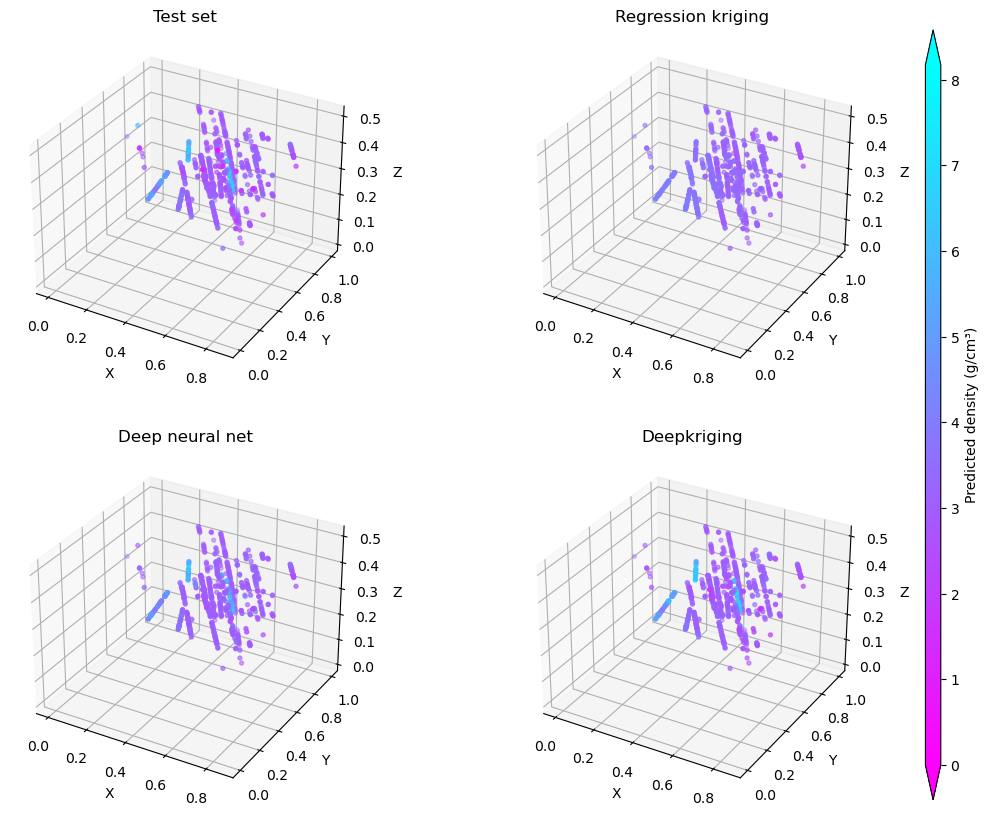

In [24]:
train_data_xyz = trainer.train_data[['X', 'Y', 'Z']].values
test_data_xyz = trainer.test_data[['X', 'Y', 'Z']].values

all_predictions = np.concatenate([test_predictions_dk.ravel(), test_predictions_nn.ravel(), test_predictions_rk.ravel(), y_test.ravel()])
min_value = all_predictions.min()*multipliers['Density_gcm3']
max_value = all_predictions.max()*multipliers['Density_gcm3']

# Define custom colormap using magenta and cyan colors, like the rest of the paper
colors = [(1, 0, 1), (0, 1, 1)]  # Magenta to Cyan
cmap_name = 'MagentaCyan'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create Matplotlib figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})

# Define scatter plots for each subplot with vmin and vmax values
scatter1 = axs[1, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_dk.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter2 = axs[1, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_nn.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter3 = axs[0, 1].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=test_predictions_rk.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)
scatter4 = axs[0, 0].scatter(test_data_xyz[:, 0], test_data_xyz[:, 1], test_data_xyz[:, 2], c=y_test.ravel()*multipliers['Density_gcm3'], cmap=custom_cmap, s=8, vmin=min_value, vmax=max_value)

# Set titles for each subplot
axs[1, 1].set_title('Deepkriging')
axs[1, 0].set_title('Deep neural net')
axs[0, 1].set_title('Regression kriging')
axs[0, 0].set_title('Test set')

# Set common labels for all subplots
for ax in axs.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Create a single colorbar
norm = Normalize(vmin=min_value, vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=axs, pad=0.05, aspect=50, extend='both')
cbar.set_label('Predicted density (g/cm³)')

#plt.tight_layout()
plt.savefig('Figures/3d_plots_all.png')  # Save the plot as PNG
plt.show()


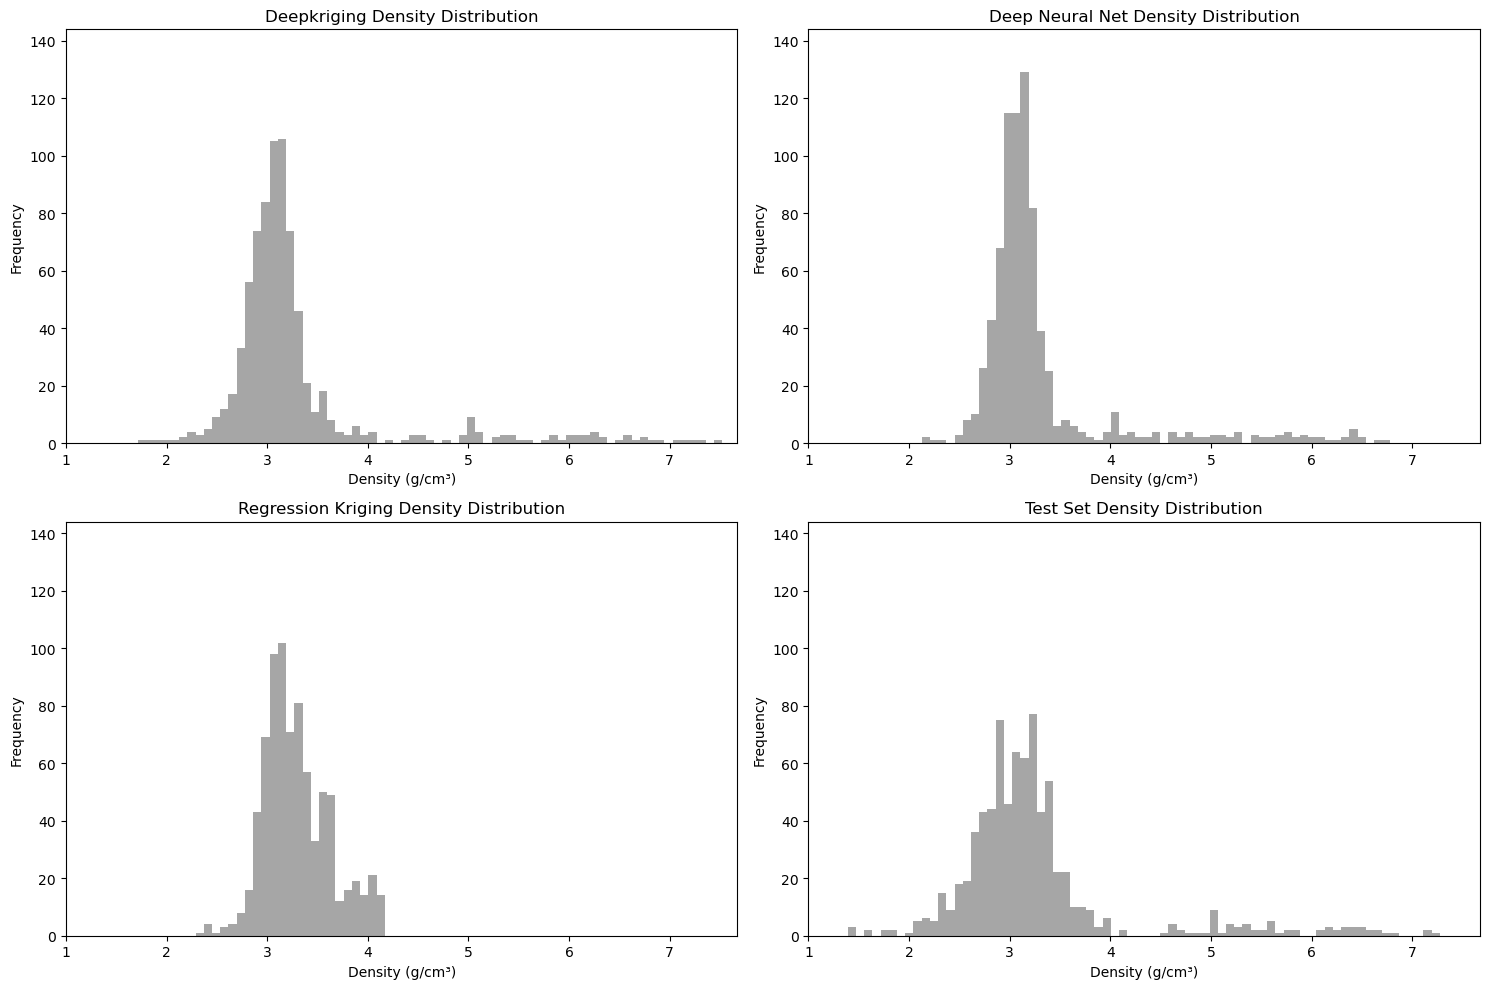

In [25]:
dk_density = test_predictions_dk.ravel() * multipliers['Density_gcm3']
nn_density = test_predictions_nn.ravel() * multipliers['Density_gcm3']
rk_density = test_predictions_rk.ravel() * multipliers['Density_gcm3']
test_density = y_test.ravel() * multipliers['Density_gcm3']

# Find global min and max for x-axis
all_densities = np.concatenate([dk_density, nn_density, rk_density, test_density])
x_min = all_densities.min() + 1
x_max = all_densities.max() - 0.5

# Find global max for y-axis by plotting histograms without displaying them
_, bins = np.histogram(all_densities, bins=100)
y_max = 0
for density in [dk_density, nn_density, rk_density, test_density]:
    counts, _ = np.histogram(density, bins=bins)
    y_max = max(y_max, counts.max()) + 5

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

#Deepkriging
axs[0, 0].hist(dk_density, bins=bins, color='gray', alpha=0.7)
axs[0, 0].set_title('Deepkriging Density Distribution')
axs[0, 0].set_xlim(x_min, x_max)
axs[0, 0].set_ylim(0, y_max)
axs[0, 0].set_xlabel('Density (g/cm³)')
axs[0, 0].set_ylabel('Frequency')

#Deep neural net
axs[0, 1].hist(nn_density, bins=bins, color='gray', alpha=0.7)
axs[0, 1].set_title('Deep Neural Net Density Distribution')
axs[0, 1].set_xlim(x_min, x_max)
axs[0, 1].set_ylim(0, y_max)
axs[0, 1].set_xlabel('Density (g/cm³)')
axs[0, 1].set_ylabel('Frequency')

#Regression kriging
axs[1, 0].hist(rk_density, bins=bins, color='gray', alpha=0.7)
axs[1, 0].set_title('Regression Kriging Density Distribution')
axs[1, 0].set_xlim(x_min, x_max)
axs[1, 0].set_ylim(0, y_max)
axs[1, 0].set_xlabel('Density (g/cm³)')
axs[1, 0].set_ylabel('Frequency')

#Test set
axs[1, 1].hist(test_density, bins=bins, color='gray', alpha=0.7)
axs[1, 1].set_title('Test Set Density Distribution')
axs[1, 1].set_xlim(x_min, x_max)
axs[1, 1].set_ylim(0, y_max)
axs[1, 1].set_xlabel('Density (g/cm³)')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [26]:
test_data_xyz = trainer.test_data[['X', 'Y', 'Z']].values
test_predictions_dk = test_predictions_dk.ravel() * multipliers['Density_gcm3']

norm = Normalize(vmin=test_predictions_dk.min(), vmax=test_predictions_dk.max())


# Create custom colormap: magenta to cyan
custom_cmap = [[0.0, 'rgb(255, 0, 255)'], [1.0, 'rgb(0, 255, 255)']]

fig = go.Figure(data=[go.Scatter3d(
    x=test_data_xyz[:, 0],
    y=test_data_xyz[:, 1],
    z=test_data_xyz[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=test_predictions_dk,
        colorscale=custom_cmap, 
        cmin=norm.vmin,  
        cmax=norm.vmax, 
        colorbar=dict(
            title='Predicted density (g/cm³)',
            tickvals=np.linspace(norm.vmin, norm.vmax, 5),  
            ticktext=[f'{v:.2f}' for v in np.linspace(norm.vmin, norm.vmax, 5)]  
        )
    )
)])

fig.update_layout(
    title='Deepkriging Predictions',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()


In [27]:
test_data_xyz = trainer.test_data[['X', 'Y', 'Z']].values
test_density = y_test.ravel() * multipliers['Density_gcm3']

# Create custom colormap: magenta to cyan
custom_cmap = [[0.0, 'rgb(255, 0, 255)'], [1.0, 'rgb(0, 255, 255)']]

# Create the 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=test_data_xyz[:, 0],
    y=test_data_xyz[:, 1],
    z=test_data_xyz[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=test_density,  # Use normalized predictions for color mapping
        colorscale=custom_cmap,  

        colorbar=dict(
            title='Density (g/cm³)',
        )
    )
)])

fig.update_layout(
    title='Test Density',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()
